In [1]:
from typing import List, Tuple
import copy
import numpy as np

from src.environment import *
from src.agents import *

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# #interface to try manually move agents
# env = CliffBoxGridWorld(render=True)
# env.reset()
# env.print_world()
# done = False
# rewards = []

# while not done:
#     action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
#     state, reward, done, info = env.step(action)
#     rewards.append(reward)
#     print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
#     env.print_world()

# print(f'rewards: {sum(rewards)}')
# print(f'action history: {env.action_history}')

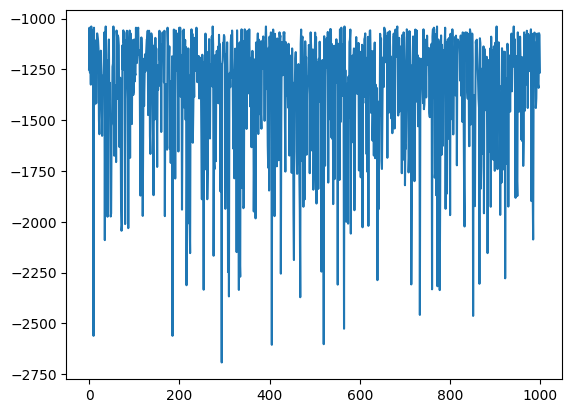

In [3]:
#example of training a random agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

In [ ]:
#train custom model
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=15000)
rewards = agent.learn()

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

In [ ]:
#visualize training results
def visualize(q_table):
    v_table = {}
    policy = {}
    for key, v in q_table.items():
        v_table[key] = # TODO: calculate the value function
        policy[key] = # TODO: calculate the policy
    state_num = len(q_table.keys())
    print(f"State space: {state_num}")
    
    # Print the largest 20 state values in v_table and the corresponding policy
    for k, val in sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:20]:
      print("v_table", k, val / state_num)
      print("policy", k, policy[k])

visualize(agent.q_table)

In [ ]:
#evaluate agent without exploration
env = CliffBoxGridWorld(render=True)
total_run = 1000
success = 0

for i in range(total_run):
    state = env.reset()
    done = False
    rewards = []
    
    while not done: 
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)
    if sum(rewards) > 0:
        success += 1
print(success/total_run)

In [ ]:
#evaluate agent with exploration and visualization
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')